In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
%matplotlib notebook

from clean.clean import extract_CLEAN, plot_components

Define a helper function generating a narrowband toneburst signal.

In [2]:
def generate_toneburst(frequency, no_cycles, delay=0, phase_change=0, delta_t=0, no_samples=0):
    """
    Generates a toneburst signal, and a corresponding time vector
    
    Parameters:
    ---
    frequency: float, central frequency in Hz
    no_cycles: int, number of cycles
    delay: float, time delay in s
    phase_change: float, phase shift in rad
    delta_t: float, time increment in s
    no_samples: int, length of the sequence
    
    Returns:
    ---
    time: ndarray, time vector
    transducer_signal: ndarray, toneburst signal
    """ 
    # if no delta_t is given, assume sampling frequency to be 20*the centre
    # frequency
    if delta_t == 0:
        sampling_rate = 20*frequency
        delta_t = 1/sampling_rate
    # if no total time is specified, assume it to be five times the total length
    # of the toneburst 
    if no_samples == 0:
        total_time = 1/frequency*no_cycles*5
        no_samples = np.round(total_time/delta_t)
    time = np.linspace(0, (no_samples - 1)*delta_t, no_samples)
    total_time = time[-1]

    if type(delay) == np.ndarray:
        # check the shape
        if len(delay.shape) == 1:
            delay = delay.reshape(-1, 1)
        elif len(delay.shape) == 2: 
            if delay.shape[0] == 1 and delay.shape[1] != 1:
                delay = delay.T
            elif delay.shape[1] == 1 and delay.shape[0] != 1:
                pass
            else:
                print('Delay shape error')
    # generate the harmonic ingredient
    harmonic = np.sin(2*np.pi*frequency*(time - delay) + phase_change)
    # apply the window
    window = (1 - np.cos(2*np.pi*frequency*(time - delay)/no_cycles))/2
    window[(time > no_cycles/frequency + delay) | (time < delay)] = 0
    transducer_signal = harmonic*window
    transducer_signal = transducer_signal.T
    window = window.T        
    return time, transducer_signal

Create the original signal applied to the transducer.

In [3]:
frequency = 1e6
sampling_freq = 20*frequency
delta_t = 1/sampling_freq
total_time = 20*(1/frequency)
no_cycles = 3
no_steps = np.round(total_time/delta_t)

Create the artificial multi-component signal

/home/michal/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


<IPython.core.display.Javascript object>


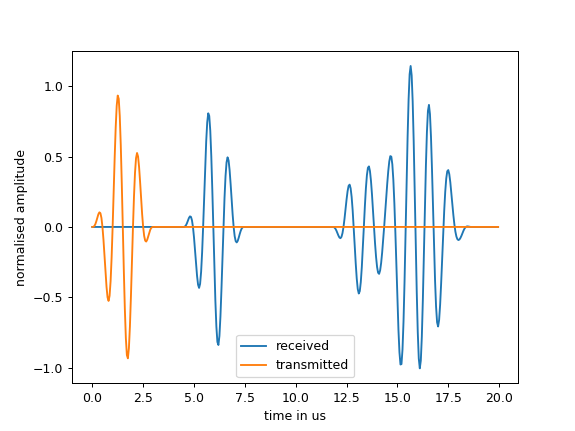

In [4]:
N = 7
A_n = np.random.rand(N)
delay_n = np.random.rand(N)*total_time*0.8
phase_n = np.random.rand(N)*2*np.pi

signal = 0
for i in range(N):
    time, burst = generate_toneburst(frequency, no_cycles, delay=delay_n[i], 
                                        phase_change=phase_n[i], no_samples=no_steps)
    signal += A_n[i]*burst
_, transmitted = generate_toneburst(frequency, no_cycles, no_samples=no_steps)
    
plt.figure()
plt.plot(time*1e6, signal, label='received')
plt.plot(time*1e6, transmitted, label='transmitted')
plt.xlabel('time in us')
plt.ylabel('normalised amplitude')
plt.legend();

## CLEAN algorithm

In [5]:
amps, dls, phss, comps = extract_CLEAN(measured_signal=signal, original_signal=transmitted, 
                                      delta_t=delta_t, threshold=0.4)

<IPython.core.display.Javascript object>


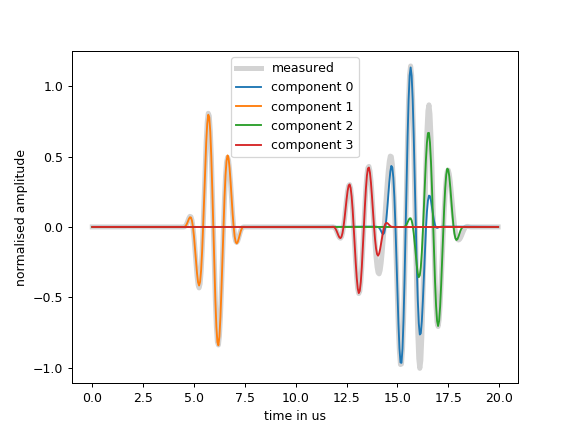

In [6]:
plot_components(time, signal, comps)